In [1]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

In [ ]:
!pip install ucimlrepo
!pip install torch
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn
!pip install imbalanced-learn


import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from ucimlrepo import fetch_ucirepo
import numpy as np
from scipy.stats import uniform, randint
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import classification_report, accuracy_score

### Terceiro Dataset

In [3]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
heart_disease = fetch_ucirepo(id=45) 
  
# data (as pandas dataframes) 
X = heart_disease.data.features 
y = heart_disease.data.targets 
  
# metadata 
print(heart_disease.metadata) 
  
# variable information 
print(heart_disease.variables) 

print ("Targets:")
print(y[y.columns[0]].unique())

{'uci_id': 45, 'name': 'Heart Disease', 'repository_url': 'https://archive.ics.uci.edu/dataset/45/heart+disease', 'data_url': 'https://archive.ics.uci.edu/static/public/45/data.csv', 'abstract': '4 databases: Cleveland, Hungary, Switzerland, and the VA Long Beach', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 303, 'num_features': 13, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': ['Age', 'Sex'], 'target_col': ['num'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1989, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C52P4X', 'creators': ['Andras Janosi', 'William Steinbrunn', 'Matthias Pfisterer', 'Robert Detrano'], 'intro_paper': {'ID': 231, 'type': 'NATIVE', 'title': 'International application of a new probability algorithm for the diagnosis of coronary artery disease.', 'authors': 'R. Detrano, A. Jánosi, W. Steinbrunn, M

## Tratamento dos datasets

### Visualização de datasets

In [4]:
print("Features:")
print(X.head())
print("\nTargets:")
print(y)
    
# Obter os metadados corretamente
variables = heart_disease.variables

# Identificar colunas categóricas automaticamente (tipo = 'Categorical' ou 'Binary', role = 'Feature')
categorical_types = ['Categorical', 'Binary']
categorical_cols = variables[
    (variables['type'].isin(categorical_types)) &
    (variables['role'] == 'Feature')
]['name'].tolist()

# Converter essas colunas para 'category'
X[categorical_cols] = X[categorical_cols].astype('category')

# Verificar categorias e numéricos
cat_cols = X.select_dtypes(include=['category', 'object']).columns.tolist()
numeric_cols = X.select_dtypes(include=['number']).columns.tolist()

print("Colunas categóricas:", cat_cols)
print("Colunas numéricas:", numeric_cols)



Features:
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   1       145   233    1        2      150      0      2.3      3   
1   67    1   4       160   286    0        2      108      1      1.5      2   
2   67    1   4       120   229    0        2      129      1      2.6      2   
3   37    1   3       130   250    0        0      187      0      3.5      3   
4   41    0   2       130   204    0        2      172      0      1.4      1   

    ca  thal  
0  0.0   6.0  
1  3.0   3.0  
2  2.0   7.0  
3  0.0   3.0  
4  0.0   3.0  

Targets:
     num
0      0
1      2
2      1
3      0
4      0
..   ...
298    1
299    2
300    3
301    1
302    0

[303 rows x 1 columns]
Colunas categóricas: ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
Colunas numéricas: ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca']


### Tratamento de Dados

In [5]:
# OneHotEncoder para as variáveis categóricas
ohe = OneHotEncoder(sparse_output=False)
X_categorical_encoded = ohe.fit_transform(X[categorical_cols])

# Nomes das colunas para as variáveis categóricas
categorical_column_names = ohe.get_feature_names_out(categorical_cols)

# Normalizar atributos numéricos
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X[numeric_cols])

# Concatenar os dados (numéricos e categóricos)
X_processed = np.hstack((X_numeric_scaled, X_categorical_encoded))

# Criar um DataFrame com os nomes das colunas
X_processed_df = pd.DataFrame(X_processed, columns=np.concatenate([numeric_cols, categorical_column_names]))

# Garantir que y seja 1D
y = heart_disease.data.targets.squeeze()

# Exibir verificação
if len(y.shape) > 1:
    print("y ainda é multidimensional. Forma de y:", y.shape)
else:
    print("y é unidimensional.")

# Convertendo y para uma série do pandas para facilitar a visualização
y_series = pd.Series(y)

# Exibindo os dados processados e o target
print("Dados de entrada (X) processados:")
print(X_processed_df.head())

print("Target (y) original ajustado:")
print(np.unique(y))
classes, counts = np.unique(y, return_counts=True)
for label, count in zip(classes, counts):
    print(f"{label}: {count}")


y é unidimensional.
Dados de entrada (X) processados:
        age  trestbps      chol   thalach   oldpeak        ca  sex_0  sex_1  \
0  0.948726  0.757525 -0.264900  0.017197  1.087338 -0.718306    0.0    1.0   
1  1.392002  1.611220  0.760415 -1.821905  0.397182  2.487269    0.0    1.0   
2  1.392002 -0.665300 -0.342283 -0.902354  1.346147  1.418744    0.0    1.0   
3 -1.932564 -0.096170  0.063974  1.637359  2.122573 -0.718306    0.0    1.0   
4 -1.489288 -0.096170 -0.825922  0.980537  0.310912 -0.718306    1.0    0.0   

   cp_1  cp_2  ...  restecg_2  exang_0  exang_1  slope_1  slope_2  slope_3  \
0   1.0   0.0  ...        1.0      1.0      0.0      0.0      0.0      1.0   
1   0.0   0.0  ...        1.0      0.0      1.0      0.0      1.0      0.0   
2   0.0   0.0  ...        1.0      0.0      1.0      0.0      1.0      0.0   
3   0.0   0.0  ...        0.0      1.0      0.0      0.0      0.0      1.0   
4   0.0   1.0  ...        1.0      1.0      0.0      1.0      0.0      0.0   

  

### Smote

In [6]:
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer

X_cleaned_df = X_processed_df.dropna()
y_cleaned = y[X_processed_df.notna().all(axis=1)]

# Aplicar SMOTE para balancear as classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_cleaned_df, y_cleaned)

classes, counts = np.unique(y_resampled, return_counts=True)
for label, count in zip(classes, counts):
    print(f"{label}: {count}")

0: 161
1: 161
2: 161
3: 161
4: 161


In [7]:
# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled
)
# Exibe as dimensões dos conjuntos de treino e teste
print("Tamanho do conjunto de treino:", X_train.shape)
print("Tamanho do conjunto de teste:", X_test.shape)
print("Tamanho dos rótulos de treino:", y_train.shape)
print("Tamanho dos rótulos de teste:", y_test.shape)

print("\nExemplo de X_train (primeiras 5 linhas):")
print(X_train[:5])  # Exibe as 5 primeiras linhas de X_train

print("\nExemplo de y_train (primeiros 5 rótulos):")
print(y_train[:5])  # Exibe os 5 primeiros rótulos de y_train

print("\nExemplo de X_test (primeiras 5 linhas):")
print(X_test[:5])  # Exibe as 5 primeiras linhas de X_test

print("\nExemplo de y_test (primeiros 5 rótulos):")
print(y_test[:5])  # Exibe os 5 primeiros rótulos de y_test

Tamanho do conjunto de treino: (563, 26)
Tamanho do conjunto de teste: (242, 26)
Tamanho dos rótulos de treino: (563,)
Tamanho dos rótulos de teste: (242,)

Exemplo de X_train (primeiras 5 linhas):
          age  trestbps      chol   thalach   oldpeak        ca    sex_0  \
50  -1.489288 -1.518995 -0.941995  0.805384 -0.896862  0.350219  1.00000   
710  0.804124  0.289734 -0.662615 -1.038208  0.764136  1.781006  0.33903   
412 -0.169464 -1.555244  0.148341  0.232164 -0.841959  0.350219  0.00000   
388 -1.135719  0.678927 -0.242175  1.068805 -0.896862 -0.345167  0.00000   
183  0.616270  1.497394  1.127981  0.498867 -0.896862 -0.718306  1.00000   

       sex_1  cp_1  cp_2  ...  restecg_2  exang_0  exang_1  slope_1  slope_2  \
50   0.00000   0.0   1.0  ...    0.00000  1.00000  0.00000      1.0      0.0   
710  0.66097   0.0   0.0  ...    1.00000  0.33903  0.66097      0.0      1.0   
412  1.00000   0.0   0.0  ...    0.36359  1.00000  0.00000      1.0      0.0   
388  1.00000   0.0   0.0 

In [8]:
#### Definição da Rede MLP

In [9]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_sizes, dropout_rate, activation_fn):
        super(MLP, self).__init__()
        layers = []
        last_dim = input_dim
        for h in hidden_sizes:
            layers.append(nn.Linear(last_dim, h))
            layers.append(activation_fn())
            layers.append(nn.Dropout(dropout_rate))
            last_dim = h
        layers.append(nn.Linear(last_dim, output_dim))
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [10]:
class MLPClassifierTorch(BaseEstimator, ClassifierMixin):
    def __init__(self, hidden_sizes=(100,), dropout_rate=0.3, learning_rate=0.001,
                 activation_fn=nn.ReLU, max_epochs=100, weight_decay=0.0,
                 early_stopping=True, patience=10, verbose=False):
        self.hidden_sizes = hidden_sizes
        self.dropout_rate = dropout_rate
        self.learning_rate = learning_rate
        self.activation_fn = activation_fn
        self.max_epochs = max_epochs
        self.weight_decay = weight_decay
        self.early_stopping = early_stopping
        self.patience = patience
        self.verbose = verbose

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)

        self.input_dim_ = X.shape[1]
        self.output_dim_ = len(np.unique(y))
        self.model_ = MLP(self.input_dim_, self.output_dim_, self.hidden_sizes,
                          self.dropout_rate, self.activation_fn)

        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=0.2, stratify=y, random_state=42)

        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.long)
        X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
        y_val_tensor = torch.tensor(y_val, dtype=torch.long)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model_.parameters(),
                               lr=self.learning_rate,
                               weight_decay=self.weight_decay)

        best_val_loss = float('inf')
        best_model_state = None
        patience_counter = 0

        for epoch in range(self.max_epochs):
            self.model_.train()
            optimizer.zero_grad()
            outputs = self.model_(X_train_tensor)
            loss = criterion(outputs, y_train_tensor)
            loss.backward()
            optimizer.step()

            self.model_.eval()
            with torch.no_grad():
                val_outputs = self.model_(X_val_tensor)
                val_loss = criterion(val_outputs, y_val_tensor).item()

            if self.verbose:
                print(f"Epoch {epoch+1}/{self.max_epochs} - Train Loss: {loss.item():.4f} - Val Loss: {val_loss:.4f}")

            if self.early_stopping:
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_model_state = self.model_.state_dict()
                    patience_counter = 0
                else:
                    patience_counter += 1
                    if patience_counter >= self.patience:
                        if self.verbose:
                            print("Early stopping triggered.")
                        break

        if best_model_state:
            self.model_.load_state_dict(best_model_state)

        return self

    def predict(self, X):
        X_tensor = torch.tensor(np.array(X), dtype=torch.float32)
        self.model_.eval()
        with torch.no_grad():
            outputs = self.model_(X_tensor)
            _, preds = torch.max(outputs, 1)
        return preds.numpy()


In [11]:
param_dist = {
    'mlp__hidden_sizes': [(64,), (128,), (64, 32), (128, 64), (256, 128)],
    'mlp__dropout_rate': uniform(0.1, 0.5),
    'mlp__learning_rate': uniform(0.0001, 0.01),
    'mlp__activation_fn': [nn.ReLU, nn.LeakyReLU, nn.Tanh],
    'mlp__max_epochs': randint(30, 300),
    'mlp__weight_decay': uniform(1e-5, 1e-2),
    'mlp__early_stopping': [True],
    'mlp__patience': [10],  # ou outro valor
    'mlp__verbose': [False],  # ou True se quiser logs
}


pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifierTorch())
])


random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=200,
    cv=StratifiedKFold(n_splits=5),
    n_jobs=-1,
    random_state=42,
    verbose=2,
    scoring='accuracy'
)

## Treinamento

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# Usar LabelEncoder para transformar as classes
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Ajustar o modelo com os dados de treino
random_search.fit(X_train, y_train_encoded)

# Obter o melhor modelo do Random Search
best_model = random_search.best_estimator_

# Fazer previsões nos dados de treino
y_train_pred_encoded = best_model.predict(X_train)

# Calcular as métricas de avaliação para o conjunto de treino
print("Métricas para os dados de treino:")

# Converter as previsões de volta para os rótulos originais
y_train_pred = label_encoder.inverse_transform(y_train_pred_encoded)
y_train = label_encoder.inverse_transform(y_train_encoded)

# Agora, as classes devem ser passadas corretamente para o classification_report
print(classification_report(y_train, y_train_pred))


In [14]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

label_mapping = {0: 'No disease', 1: 'Mild disease', 2: 'Moderate disease', 3: 'Significant disease', 4: 'Severe disease'}

# Codificando os rótulos originais
label_encoder = LabelEncoder()
label_encoder.fit(list(label_mapping.keys()))  
y_test_encoded = label_encoder.transform(y_test)  

# Prever os rótulos no conjunto de teste
y_pred = best_model.predict(X_test)
y_pred = label_encoder.inverse_transform(y_pred)  

# Calcular a acurácia
accuracy = accuracy_score(y_test, y_pred) * 100
print("Melhores hiperparâmetros encontrados:")
print(random_search.best_params_)
print(f"Acurácia no conjunto de teste: {accuracy:.2f}%")

# Exibir relatório com nomes de rótulos
target_names = [label_mapping[i] for i in sorted(label_mapping)]

# Relatório de classificação com as classes mapeadas corretamente
print("Relatório de Classificação:")
print(classification_report(y_test_encoded, y_pred, target_names=target_names, labels=[0, 1, 2, 3, 4]))


Melhores hiperparâmetros encontrados:
{'mlp__activation_fn': <class 'torch.nn.modules.activation.ReLU'>, 'mlp__dropout_rate': np.float64(0.1376731280030641), 'mlp__early_stopping': True, 'mlp__hidden_sizes': (256, 128), 'mlp__learning_rate': np.float64(0.003950977286019253), 'mlp__max_epochs': 190, 'mlp__patience': 10, 'mlp__verbose': False, 'mlp__weight_decay': np.float64(0.0031792200515627766)}
Acurácia no conjunto de teste: 85.54%
Relatório de Classificação:
                     precision    recall  f1-score   support

         No disease       0.95      0.76      0.84        49
       Mild disease       0.69      0.85      0.77        48
   Moderate disease       0.89      0.81      0.85        48
Significant disease       0.88      0.86      0.87        49
     Severe disease       0.92      1.00      0.96        48

           accuracy                           0.86       242
          macro avg       0.87      0.86      0.86       242
       weighted avg       0.87      0.86    

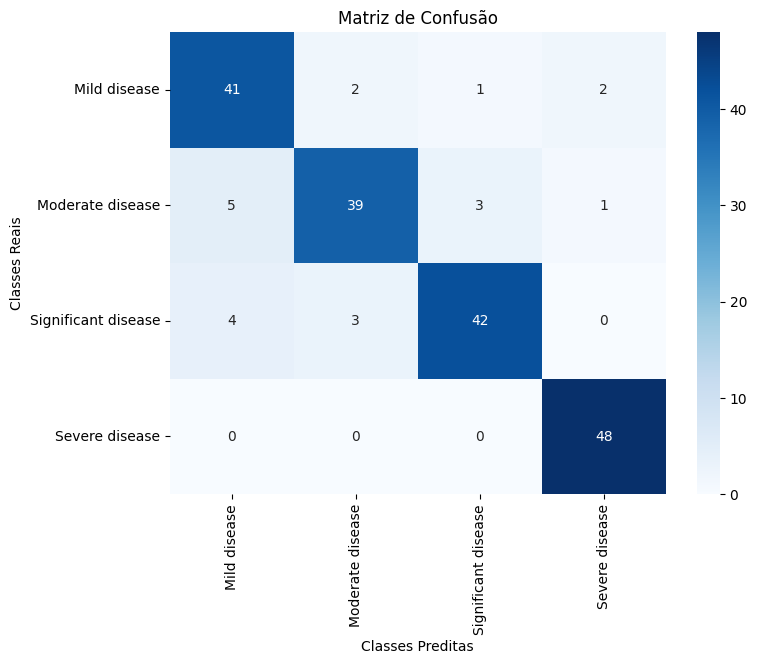

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Definir o mapeamento de rótulos para o Heart Disease Dataset
label_mapping = {0: 'No disease', 1: 'Mild disease', 2: 'Moderate disease', 3: 'Significant disease', 4: 'Severe disease'}

# Calcular a matriz de confusão com as classes relevantes
cm = confusion_matrix(y_test, y_pred, labels=[1,2,3,4])

# Plotar a matriz de confusão com seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[label_mapping[i] for i in classes_to_use], 
            yticklabels=[label_mapping[i] for i in classes_to_use])
plt.title("Matriz de Confusão")
plt.xlabel("Classes Preditas")
plt.ylabel("Classes Reais")
plt.savefig("matriz_confusao_3.png", dpi=300, bbox_inches='tight')
plt.show()
